# Build and test some models

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import seaborn as sns
import sql_utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
import pickle
import time
import psycopg2 as pg
%matplotlib inline

In [4]:
# plot in seaborn style
sns.set(font_scale=1.5, style="whitegrid")
# store the figure path for easy plotting to file
figpath = '/Users/bkhurley/git/insight/project/beat_the_crowd/figures/'

## Pull the data from postgres

In [5]:
# select and join the BART and weather data from postgres
bart_stn_df = sql_utils.pg2pd_join(table1='bart_entry_exit', table2='bart_station_info',
                           on1='bart_entry_exit.station', on2='bart_station_info.abbr')

In [6]:
bart_stn_df.head()

,id,date,hour,direction,station,entries,exits,day,month,index,abbr,address,city,county,gtfs_latitude,gtfs_longitude,name,state,zipcode,wu_loc_abbr
0,0,2011-01-01,0,northbound,12TH,16,102,Saturday,1,0,12TH,1245 Broadway,Oakland,alameda,37.803768,-122.271450,12th St. Oakland City Center,CA,94612,KOAK
1,1,2011-01-01,0,northbound,16TH,168,26,Saturday,1,1,16TH,2000 Mission Street,San Francisco,sanfrancisco,37.765062,-122.419694,16th St. Mission,CA,94110,KSFO
2,2,2011-01-01,0,northbound,19TH,19,91,Saturday,1,2,19TH,1900 Broadway,Oakland,alameda,37.808350,-122.268602,19th St. Oakland,CA,94612,KOAK
3,3,2011-01-01,0,northbound,24TH,72,32,Saturday,1,3,24TH,2800 Mission Street,San Francisco,sanfrancisco,37.752470,-122.418143,24th St. Mission,CA,94110,KSFO
4,4,2011-01-01,0,northbound,BALB,72,5,Saturday,1,5,BALB,401 Geneva Avenue,San Francisco,sanfrancisco,37.721585,-122.447506,Balboa Park,CA,94112,KSFO


In [7]:
# drop redundant columns
bart_stn_df.drop(['exits', 'abbr', 'address', 'city', 'county', 'gtfs_latitude', 
                  'gtfs_longitude', 'name', 'state', 'zipcode'], axis=1, inplace=True)

In [8]:
# now get weather data from db. we will join in pandas
sql_query = '''
    SELECT datestamp, wu_loc_abbr, max_temperature, precipitation, rain FROM weather;
    '''
dbname = 'bart_db'
username = 'bkhurley'
con = None
con = pg.connect(database=dbname, user=username)
# query db and return in a df
weather_df = pd.read_sql_query(sql_query,con)

In [9]:
# merge weather data with BART data
bart_weather_df = pd.merge(left=bart_stn_df, right=weather_df, 
                           left_on=['date', 'wu_loc_abbr'],
                           right_on=['datestamp', 'wu_loc_abbr'])
# remove redundant datestamp col
bart_weather_df.drop(['datestamp'], axis=1, inplace=True)

In [10]:
bart_weather_df.head()

,id,date,hour,direction,station,entries,day,month,index,wu_loc_abbr,max_temperature,precipitation,rain
0,0,2011-01-01,0,northbound,12TH,16,Saturday,1,0,KOAK,53.0,0.08,1
1,2,2011-01-01,0,northbound,19TH,19,Saturday,1,2,KOAK,53.0,0.08,1
2,12,2011-01-01,0,northbound,MCAR,7,Saturday,1,24,KOAK,53.0,0.08,1
3,16,2011-01-01,0,northbound,ROCK,2,Saturday,1,35,KOAK,53.0,0.08,1
4,20,2011-01-01,0,northbound,WOAK,10,Saturday,1,45,KOAK,53.0,0.08,1


-------
## Transform features before feeding to model
Generate some new features, and transform categorical features to binary dummy variables 

In [11]:
# take a look at the current data types
bart_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126069 entries, 0 to 2126068
Data columns (total 13 columns):
id                 int64
date               object
hour               object
direction          object
station            object
entries            int64
day                object
month              object
index              int64
wu_loc_abbr        object
max_temperature    float64
precipitation      float64
rain               int64
dtypes: float64(2), int64(4), object(7)
memory usage: 227.1+ MB


In [12]:
# restrict to only the columns to be used in the models
model_data = bart_weather_df[['hour', 'direction', 'station', 'entries', 
                              'day','month', 'max_temperature', 'rain']]
# remove NaN from data before training
model_data = model_data.loc[(~model_data.isnull().any(axis=1)), :]

 ### Transform categorical features to binary dummy variables

In [13]:
# create a weekday dummy variable
model_data['weekday'] = 0
model_data.loc[model_data['day'].isin([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday'] = 1

In [14]:
# transform direction to binary dummy
model_data['northbound'] = 0
model_data.loc[model_data['direction'] == 'northbound', 'northbound'] = 1
# drop the original categorical feature
model_data.drop('direction', axis=1, inplace=True)

In [15]:
model_data.head()

,hour,station,entries,day,month,max_temperature,rain,weekday,northbound
0,0,12TH,16,Saturday,1,53.0,1,0,1
1,0,19TH,19,Saturday,1,53.0,1,0,1
2,0,MCAR,7,Saturday,1,53.0,1,0,1
3,0,ROCK,2,Saturday,1,53.0,1,0,1
4,0,WOAK,10,Saturday,1,53.0,1,0,1


In [16]:
# treat hour and month as ordinal continuous features
model_data['hour'] = model_data['hour'].astype('int')
model_data['month'] = model_data['month'].astype('int')

In [19]:
# make a separate data set w/ no day name features
no_day_data = model_data.drop(labels='day', axis=1)

In [20]:
no_day_data.head()

,hour,station,entries,month,max_temperature,rain,weekday,northbound
0,0,12TH,16,1,53.0,1,0,1
1,0,19TH,19,1,53.0,1,0,1
2,0,MCAR,7,1,53.0,1,0,1
3,0,ROCK,2,1,53.0,1,0,1
4,0,WOAK,10,1,53.0,1,0,1


In [21]:
# transform categorical features into binary dummy variables
model_data_binary = pd.get_dummies(model_data)
model_data_binary.head()

,hour,entries,month,max_temperature,rain,weekday,northbound,station_12TH,station_16TH,station_19TH,...,station_SSAN,station_WCRK,station_WOAK,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,0,16,1,53.0,1,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,19,1,53.0,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,7,1,53.0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,2,1,53.0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,10,1,53.0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [22]:
# also get dummies for the no-day data
no_day_data_binary = pd.get_dummies(no_day_data)
no_day_data_binary.head()

,hour,entries,month,max_temperature,rain,weekday,northbound,station_12TH,station_16TH,station_19TH,...,station_NCON,station_ORIN,station_PHIL,station_POWL,station_ROCK,station_SBRN,station_SFIA,station_SSAN,station_WCRK,station_WOAK
0,0,16,1,53.0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,19,1,53.0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,7,1,53.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,53.0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,10,1,53.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Before submitting to a model, check for multicolinearity among features

In [24]:
y = model_data_binary['entries']
X = model_data_binary.drop('entries', axis=1)
y_noday = no_day_data_binary['entries']
X_noday = no_day_data_binary.drop('entries', axis=1)

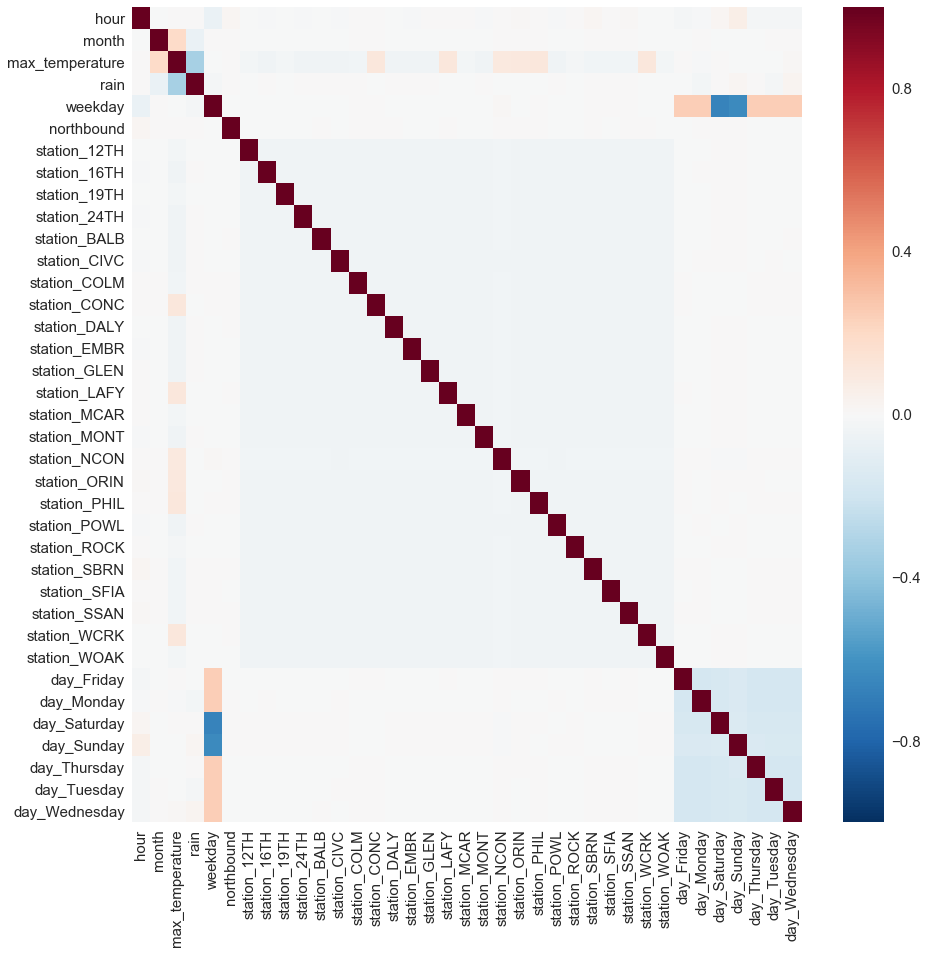

In [25]:
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(X.corr())

None of the features look alarmingly correlated with one another. May consider trying a model with day names only and another with weekend/weekday only & see if either fit any better or worse than model containing both.

-------
# Linear Regression
Train regression models to predict passenger crowding using the above features. 

## Least-squares regression
First, use a simple *ordinary least-squares (OLS) regression* model

#### Partition data for validation
Partition into 80% training set and 20% test set. 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5)

# do train test split on data w/ no day names
X_train_noday, X_test_noday, y_train_noday, y_test_noday = train_test_split(
    X_noday, y_noday, test_size=0.2, random_state=5)

### Train model
Fit an OLS regression model to the training data

In [53]:
ols_reg = LinearRegression()
ols_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Evaluate model predictions

In [54]:
figpath = '/Users/bkhurley/git/insight/project/beat_the_crowd/figures/'

In [55]:
predicted = ols_reg.predict(X_test)

In [57]:
print('R2 for OLS Regression: %.2f' % metrics.r2_score(y_test, predicted))

R2 for OLS Regression: 0.17


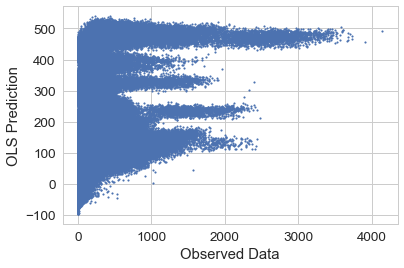

In [58]:
plt.scatter(y_test, predicted, s=3)
plt.xlabel('Observed Data')
plt.ylabel('OLS Prediction')
plt.savefig(figpath + 'ols_predict.png')

Looks like the OLS model is pretty biased and fits poorly. This is likely due to the extreme outliers of the high-volume stations at high-volume times (e.g., downtown SF stations at rushour).

### Evaluate model

In [59]:
print('Accuracy metrics for OLS Regression:')
print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R^2: ', metrics.r2_score(y_test, predicted))

Accuracy metrics for OLS Regression:
MAE: 157.152254004
MSE: 77994.9628304
RMSE: 279.27578275
R^2:  0.169697017805


#### Residuals

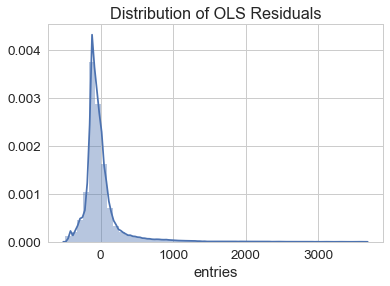

In [60]:
sns.distplot((y_test-predicted),bins=50);
plt.title('Distribution of OLS Residuals')
plt.savefig(figpath + 'ols_resid.png')

In [61]:
# dump model to pickle file so I can pick it up in Flask
with open('ols.pkl', 'wb') as fid:
    pickle.dump(ols_reg, fid,2) 

In [62]:
#For building feature vectors, create a dataframe with the dummy variables
feats = model_data_binary.drop('entries', axis=1)
index_dict = dict(zip(feats.columns,range(feats.shape[1])))
with open('cat.pkl', 'wb') as fid:
    pickle.dump(index_dict, fid,2) 

## Ridge Regression
OLS did not perform very good. With the one-hot encoding of multi-class categoricals, we ended up with 70+ features. This might lead to an over-fitting to the training data. Let's use a ridge regression to impart some regularization and shrink the less informative features.

### Train model
Fit ridge model under each tuning value, and select best penalty (`alpha`) using cross-validation.  

In [57]:
# define array of tuning values to test
tuning = np.logspace(0, 7, num=15)
# fit ridge model to data using 5-fold CV
ridge = RidgeCV(alphas=tuning, cv=5)

In [193]:
# start timer
start = time.time()

ridge.fit(X, y)

# end timer
end = time.time()
elapsed = end-start
print(str(elapsed/60) + ' minutes elapsed' )

34.65736091931661 minutes elapsed


In [194]:
print('Optimal tuning parameter value: ', ridge.alpha_)

Optimal tuning parameter value:  1000.0


### Evaluate model predictions

In [195]:
ridge_predictions = ridge.predict(X)

In [196]:
print('MSE:', metrics.mean_squared_error(y, ridge_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, ridge_predictions)))
print('R^2: ', ridge.score(X, y))

MSE: 67967.7997637
RMSE: 260.706347763
R^2:  0.288578701692


No improvement in model fit compared to the simple OLS regression. Predictions are still pretty biased, as shown below. Perhaps a polynomial model would improve things.

Text(0,0.5,'Ridge-Predicted Crowd Levels')

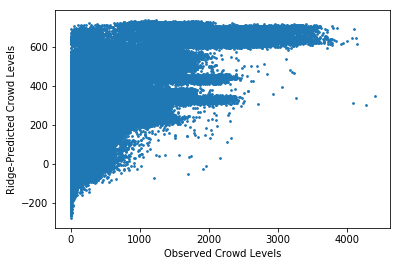

In [198]:
plt.scatter(y, ridge_predictions, s=3)
plt.xlabel('Observed Crowd Levels')
plt.ylabel('Ridge-Predicted Crowd Levels')

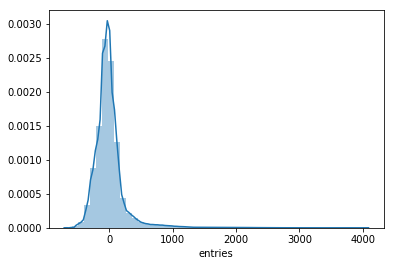

In [199]:
sns.distplot((y-ridge_predictions),bins=50)

## Random Forest Regression

Start w/ random forest model w/ individual days and weekdays as features

In [25]:
# train model
rf_reg = RandomForestRegressor(random_state=5, oob_score=True)
start = time.time()
rf_reg.fit(X_train, y_train)
rf_fit = time.time() - start
print("RF model fitted in %.3f s"
      % rf_fit)

Train another RF with no feature for individual days, just weekdays

In [76]:
# random forest instance to be run in parallel on all available CPUs
rf_reg_noday = RandomForestRegressor(random_state=5, verbose=2, n_jobs=-1,
                                     n_estimators=1000, min_samples_leaf=50,
                                     oob_score=True)

In [77]:
# fit RF model for data set w/ day names removed
start = time.time()
rf_reg_noday.fit(X_train_noday, y_train_noday)

building tree 1 of 1000building tree 3 of 1000building tree 4 of 1000building tree 2 of 1000



building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.3min


building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000building tree 44 of 1000

building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 17.0min


building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tree 196 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 38.5min


building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 67.8min


building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tre

building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000building tree 994 of 1000

building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 103.7min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=50, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=5, verbose=2, warm_start=False)

### Fit and evaluate model

In [78]:
# prediction for model trained on data w/ no day name
predicted_test_noday = rf_reg_noday.predict(X_test_noday)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   33.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   52.5s finished


In [42]:
# fit with 1000 estimators and 50 minimum leaf samples, 300 max depth
print('Accuracy metrics for RF model fitted with weekend (raher than day name):')
print('MSE:', metrics.mean_squared_error(y_test_noday, predicted_test_noday))
print('MAE:', metrics.mean_absolute_error(y_test_noday, predicted_test_noday))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_noday, predicted_test_noday)))
print('R^2: ', metrics.r2_score(y_test_noday, predicted_test_noday))

Accuracy metrics for RF model fitted with weekend (no day name):
MSE: 9476.22944843
MAE: 39.6174065503
RMSE: 97.3459267172
R^2:  0.90070238699


In [79]:
# fit with 1000 estimators and 50 minimum leaf samples, no max depth
print('Accuracy metrics for RF model fitted with weekend (rather than day name):')
print('MSE:', metrics.mean_squared_error(y_test_noday, predicted_test_noday))
print('MAE:', metrics.mean_absolute_error(y_test_noday, predicted_test_noday))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_noday, predicted_test_noday)))
print('R^2: ', metrics.r2_score(y_test_noday, predicted_test_noday))

Accuracy metrics for RF model fitted with weekend (no day name):
MSE: 6993.9713325
MAE: 32.5320107311
RMSE: 83.6299667135
R^2:  0.926712975603


Compare these model metrics to the earlier OLS and Ridge regression models. <br>
We see that that the fit with a Random Forest regression is *phenomenally* better.<br>
Explaining 93% of the variance!

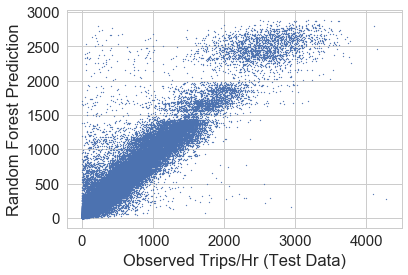

In [86]:
# predictions for data w/ no day names & optimized hyper-params
plt.scatter(y_test_noday, predicted_test_noday, s= 1)
plt.xlabel('Observed Trips/Hr (Test Data)')
plt.ylabel('Random Forest Prediction')
plt.savefig(figpath + 'rf_predict.png', bbox_inches='tight')

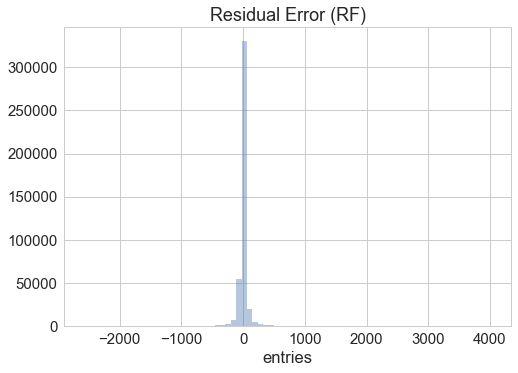

In [62]:
# check out the distribution of residuals
sns.distplot((y_test_noday-predicted_test_noday),bins=75, kde=False)
plt.title('Residual Error (RF)')

We can see from the two above plots that model predictions tightly correspond to the observed data, and prediction error is no longer highly skewed like in the OLS and Ridge Regression models.

### Feature Importance

In [87]:
importance_noday = rf_reg_noday.feature_importances_

In [88]:
std = np.std([importance_noday for tree in rf_reg_noday.estimators_],
             axis=0)
indices = np.argsort(importance_noday)[::-1]
sorted_featnames = X_noday.columns[indices]

In [89]:
# Print the feature ranking
print("Feature ranking (optimized hyper-params):")
for f in np.arange(X_noday.shape[1]):
    print("%d. %s (%f)" % (f + 1, sorted_featnames[f], importance_noday[indices[f]]))

Feature ranking (optimized hyper-params):
1. hour (0.461493)
2. weekday (0.129306)
3. northbound (0.087231)
4. station_POWL (0.042113)
5. station_MONT (0.040137)
6. station_EMBR (0.039135)
7. station_CIVC (0.026067)
8. station_GLEN (0.020282)
9. station_PHIL (0.018012)
10. station_DALY (0.017642)
11. station_BALB (0.011364)
12. station_16TH (0.011187)
13. station_24TH (0.009158)
14. station_WOAK (0.008242)
15. station_COLM (0.008237)
16. station_CONC (0.007743)
17. station_WCRK (0.007500)
18. station_MCAR (0.007203)
19. station_12TH (0.006094)
20. station_19TH (0.006065)
21. station_ROCK (0.005799)
22. station_SSAN (0.005230)
23. max_temperature (0.004731)
24. station_SBRN (0.004051)
25. station_LAFY (0.003570)
26. month (0.003317)
27. station_NCON (0.003202)
28. station_SFIA (0.002899)
29. station_ORIN (0.002769)
30. rain (0.000218)


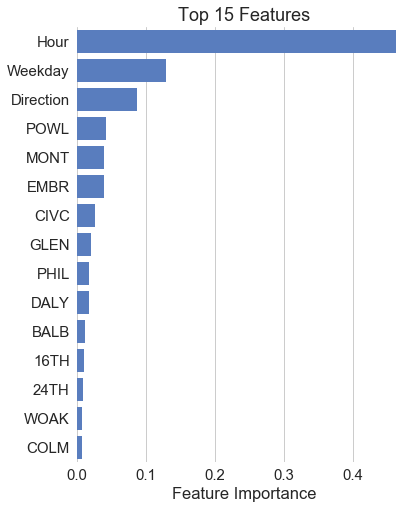

In [90]:
# Plot ranked feature importance
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes("muted")
featimport = sns.barplot(importance_noday[indices[0:15]], sorted_featnames[0:15],
                         color='b')
featimport.set_yticklabels(['Hour', 'Weekday', 'Direction', 'POWL', 'MONT',
                            'EMBR', 'CIVC', 'GLEN', 'PHIL', 'DALY',
                            'BALB', '16TH', '24TH', 'WOAK', 'COLM'])
#                            'COLM', 'WCRK', 'CONC', 'MCAR', '19TH'])

plt.title('Top 15 Features')
ax.set(xlabel="Feature Importance")
sns.despine(left=True, bottom=True)
plt.savefig(figpath + 'randforest_featimport_top15_opt.png', bbox_inches='tight')


In [85]:
# pickle the updated model for web deployment in Flask
joblib.dump(rf_reg_noday, 'rf_reg_updated.pkl')

['rf_reg_updated.pkl']

In [ ]:
#For building feature vectors, create a dataframe with the dummy variables
index_dict = dict(zip(X_noday.columns,range(X_noday.shape[1])))
joblib.dump('cat_updated.pkl')